In [1]:
%load_ext autoreload

In [2]:
import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


from __future__ import division
import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
# from baselines import deepq
# import baselines.common.tf_util as U

In [3]:
%autoreload

In [4]:
def save_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.save(sess, save_path=path)

def load_tf_vars(sess, scope, path):
  saver = tf.train.Saver([v for v in tf.global_variables() if v.name.startswith(scope + '/')])
  saver.restore(sess, path)

In [5]:
data_dir = os.path.join('data', '1.2')

In [6]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"utils/rover_left.png",
        RIGHT:"utils/rover_right.png",
        DOWN:"utils/rover_down.png",
        UP:"utils/rover_up.png",
        NOOP:"utils/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

# tile_map = [
#         "F22222FF1",
#         "U31122FU1",
#         "UF1112FU1",
#         "UFUU1SFU1",
#         "UFFU1FFU3",
#         "3222UFS1U",
#         "UUU22F1FU",
#         "FSSFS12SF",
#         "FSFF121FF",
#         "S1S2SFFSF",
#         "FUUUFFSFU",
#         "U3UUUFSFU",
#         "FFFUUFUUU"
#     ]

tile_map = [
        "2FFFUFFF1",
        "FFFU3UFFF",
        "FFFFUFFFF",
        "FSFUUUFSF",
        "FSUUSUUSF",
        "FSFUUUFSF",
        "FFFFUFFFF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':3.0,
              'S':0.0,
              'U':0.0}

tile_reward_modifier = lambda r,x,y,mx,my: r #* 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.001,0.0,0.0,0.999)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

true_tps = np.array([[[0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 0.999]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.1, 0.],
  [0.0, 0.999]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.001],
  [0.0, 0.999]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.95

alpha = 0.0001

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [7]:
# reward_normalizer = (1-gamma)/(np.max(reward_map))
# reward_map *= reward_normalizer
# time_penalty *= reward_normalizer

In [8]:
# temperature = 1/(reward_normalizer)
# print(temperature)

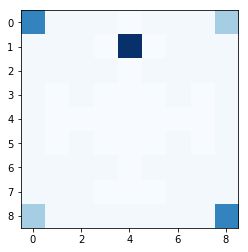

In [9]:
plt.imshow(reward_map, cmap="Blues")

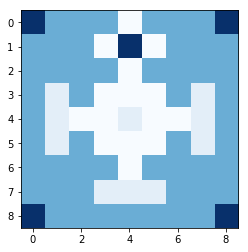

In [10]:
plt.imshow(texture_map, cmap="Blues")

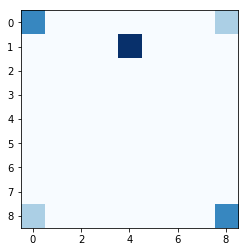

In [11]:
plt.imshow(reward_map - texture_map, cmap="Blues")

In [12]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

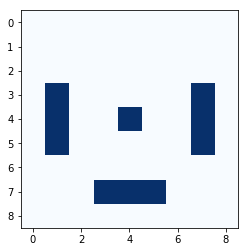

In [13]:
binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")

In [14]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning

In [15]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [16]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = logsumexp(prevQ, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = R + gamma * np.sum(T * V_broad, axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [17]:
def tabsoftq_learn_Qs(mdp):
    R = np.repeat(mdp.rewards[np.newaxis].T, 5, axis=1)
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [18]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [19]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  
/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


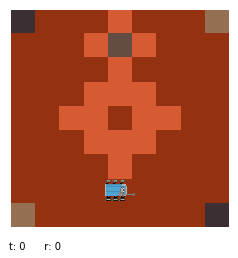

[39.75905502 39.86087281 40.01341789 32.76348306 39.07453385]
2
[0.2562743  0.28374222 0.33050151 0.00023473 0.12924724]
(4, 7) b'S'
(4, 8) b'F'


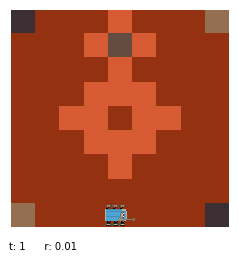

[40.50607293 33.08111636 40.70789065 39.69430807 39.59669369]
2
[0.32561952 0.00019413 0.39843617 0.14459905 0.13115113]
(4, 8) b'F'
(4, 0) b'U'


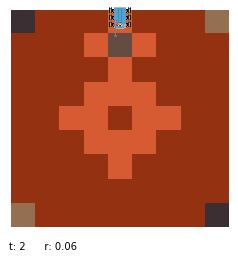

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


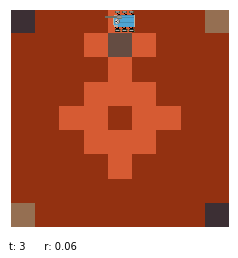

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


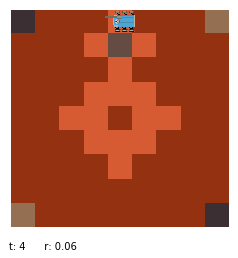

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


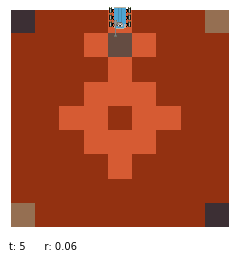

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


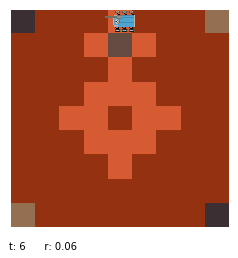

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


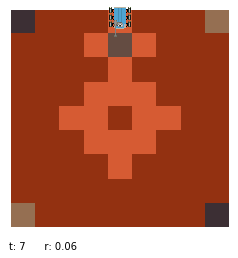

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


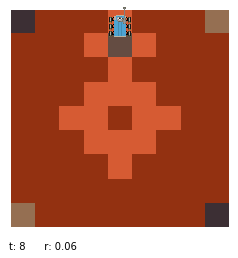

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
3
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


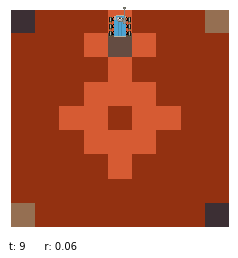

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
3
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


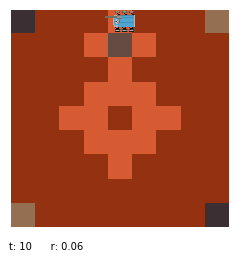

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


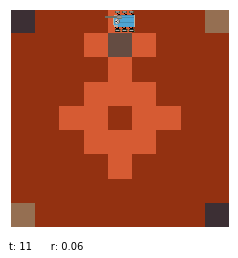

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


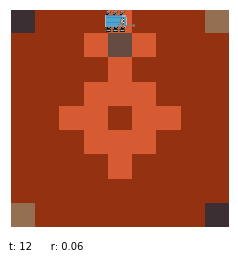

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
2
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


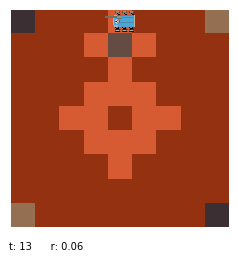

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


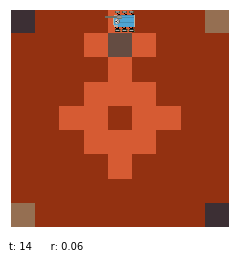

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


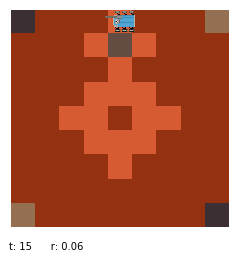

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


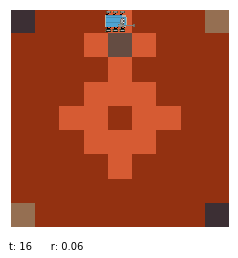

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
2
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


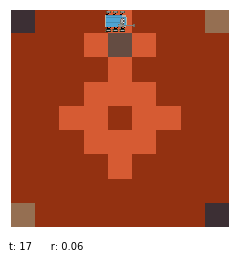

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
2
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


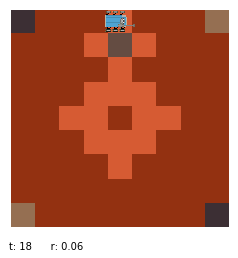

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
2
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


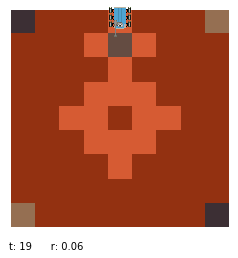

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


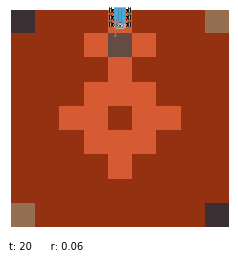

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


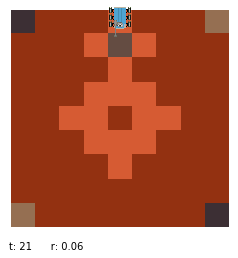

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


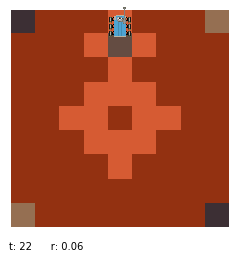

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
3
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


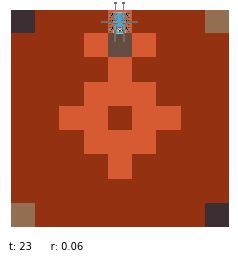

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
4
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


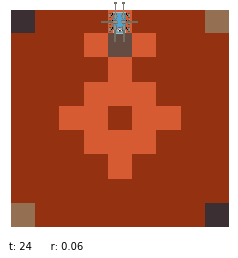

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
4
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


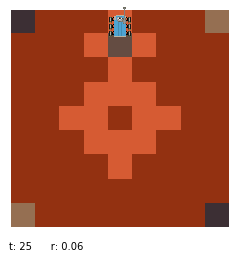

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
3
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


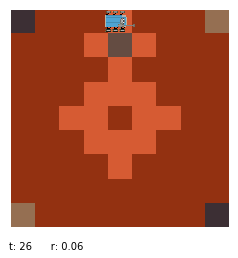

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
2
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


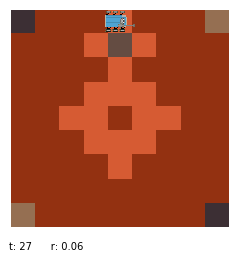

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
2
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


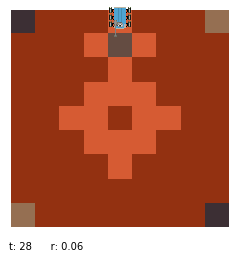

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


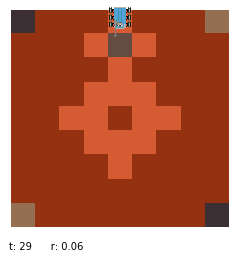

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


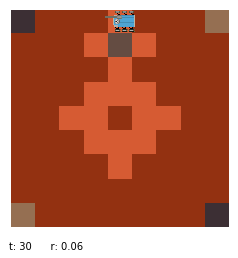

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


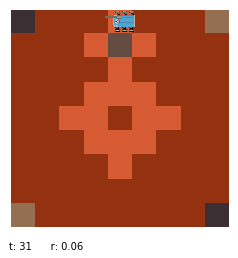

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


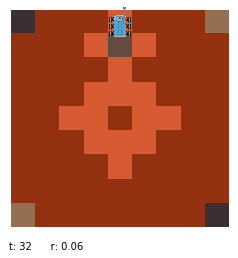

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
3
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


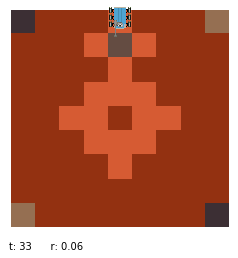

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


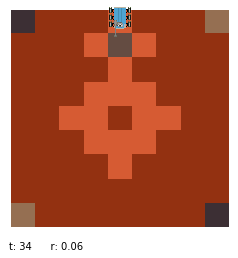

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


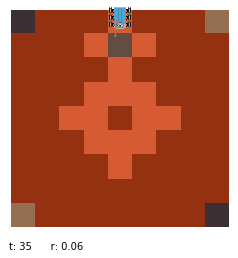

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


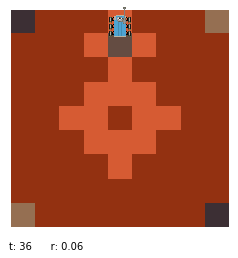

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
3
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


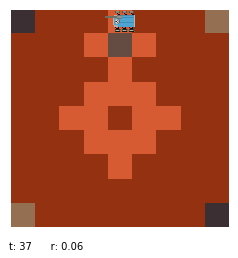

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
0
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


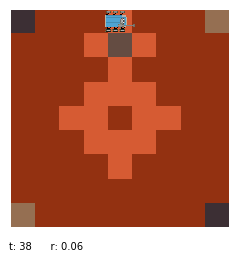

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
2
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


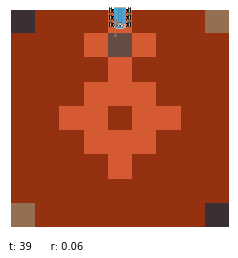

[30.80838861 30.82614617 30.80819832 30.80679286 30.79804421]
1
[0.19976666 0.20334571 0.19972865 0.19944814 0.19771084]
(4, 0) b'U'
(4, 0) b'U'


In [20]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q*50),Qs=Q)


# NN IDL

In [21]:
train_demo_example_idxes = None
val_demo_example_idxes = None

gamma = 0.99
iterations = 100000
learning_rate = 1e-1
batch_size = 512
sq_td_err_penalty = 1e0
trans_err_penalty = 1e2


q_n_layers = 1
q_layer_size = 16384
q_activation = tf.nn.relu
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 64
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


constraint_sampling_freq = 100000
constraint_batch_size = batch_size
n_constraint_rollouts_per_env = 100

val_update_freq = 1

In [22]:
n_obs_feats = 2
n_act_dim = 5
featurize_states = lambda states: np.array([mdp.s_to_grid(state) for state in states])
featurize_acts = lambda a: a
n_dirs = 5

In [23]:
def build_mlp(
    input_placeholder,
    output_size,
    scope,
    n_layers=1,
    size=256,
    activation=tf.nn.relu,
    output_activation=None,
    reuse=False
      ):
    out = tf.cast(input_placeholder, tf.float32)
    with tf.variable_scope(scope, reuse=reuse):
        for _ in range(n_layers):
            out = tf.layers.dense(out, size, activation=activation)
        out = tf.layers.dense(out, output_size, activation=output_activation)
    return out

In [24]:
def nn_vectorize_rollouts(sas_obs, adt_obs):
    states, acts, next_states = zip(*sas_obs)
    _, dirs, tiles = zip(*adt_obs)
    states_feats = featurize_states(states)
    states = np.expand_dims(np.array(states), axis=1)
    actions = np.expand_dims(np.array(acts), axis=1)
    next_states_feats = featurize_states(next_states)
    next_states = np.expand_dims(np.array(next_states), axis=1)
    dirs = np.expand_dims(np.array(dirs), axis=1)
    tiles = np.expand_dims(np.array(tiles), axis=1)
    return (states, states_feats, actions, next_states, next_states_feats, dirs, tiles)

def get_rollout_indexes(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    random.shuffle(demo_example_idxes)
    n_train_demo_examples = int(0.9 * len(demo_example_idxes))
    train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
    val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
    return (train_demo_example_idxes, val_demo_example_idxes)

def sample_batch(rollouts, indexes, size=None):
    idxes = random.sample(indexes, size) if size is not None else indexes
    demo_batch = [comp[idxes] for comp in rollouts]
    return demo_batch

def generate_constraints(mdp):
    s = np.arange(mdp.nS)
    a = np.arange(mdp.nA) 
    sa = np.transpose([np.tile(s, len(a)), np.repeat(a, len(s))])
    states, acts = sa[:,0], sa[:,1]
    feat_states = featurize_states(states)
    tiles = np.expand_dims(np.array([mdp.get_tile_type(s) for s in states]), axis=1)
    acts_array = np.expand_dims(acts,axis=1)
    rewards = np.array([mdp.get_reward(states[i], acts[i]) for i in range(len(states))])
    sprimes = mdp.get_possible_sprimes(feat_states)

    return feat_states, acts_array, rewards, sprimes, tiles

In [25]:
# im_scope =  str(uuid.uuid4())
# q_scope = str(uuid.uuid4())
# invsas_scope = str(uuid.uuid4())
# invadt_scope = str(uuid.uuid4())

# with open(os.path.join(data_dir, 'im_scope.pkl'), 'wb') as f:
#     pkl.dump(im_scope, f)

# with open(os.path.join(data_dir, 'q_scope.pkl'), 'wb') as f:
#     pkl.dump(q_scope, f)

# with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'wb') as f:
#     pkl.dump(invsas_scope, f)
    
# with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'wb') as f:
#     pkl.dump(invadt_scope, f)

In [26]:
with open(os.path.join(data_dir, 'im_scope.pkl'), 'rb') as f:
    im_scope = pkl.load(f)

with open(os.path.join(data_dir, 'q_scope.pkl'), 'rb') as f:
    q_scope = pkl.load(f)

with open(os.path.join(data_dir, 'invsas_scope.pkl'), 'rb') as f:
    invsas_scope = pkl.load(f)
    
with open(os.path.join(data_dir, 'invadt_scope.pkl'), 'rb') as f:
    invadt_scope = pkl.load(f)

In [27]:
sess = tf.Session()

In [28]:
demo_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dot")
demo_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="dtt")
demo_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="dat")
demo_next_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="dnot")
demo_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dotf")
demo_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="dnotf")
demo_dir_t_ph = tf.placeholder(tf.int32, [None, 1], name="ddt")
demo_batch_size_ph = tf.placeholder(tf.int32, name="dbs")

constraint_obs_t_ph = tf.placeholder(tf.int32, [None,1], name="cot")
constraint_tile_t_ph = tf.placeholder(tf.int32, [None, 1], name="ctt")
constraint_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_obs_feats], name="cotf")
constraint_act_t_ph = tf.placeholder(tf.int32, [None, 1], name="cat")
constraint_rew_t_ph = tf.placeholder(tf.float32, [None], name="crt")
constraint_next_obs_t_feats_ph = tf.placeholder(tf.int32, [None, n_dirs, n_obs_feats], name="cnotf")
constraint_batch_size_ph = tf.placeholder(tf.int32, name="cbs")

In [29]:
boltz_beta = 50

demo_q_t = build_mlp(demo_obs_t_feats_ph,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation) * boltz_beta

# demo_v_t = tf.reduce_logsumexp(
#   tf.stack([build_mlp(
#     extract_task(demo_obs_t_ph, train_task_idx),
#     n_act_dim, q_scope+'-'+str(train_task_idx), 
#     n_layers=q_n_layers, size=q_layer_size,
#     activation=q_activation, output_activation=q_output_activation,
#     reuse=True
#   ) for train_task_idx in range(n_train_tasks)], axis=0),
#   axis=2)

In [30]:
demo_v_t = tf.reduce_logsumexp(demo_q_t, axis=1)

action_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_act_t_ph], axis=1)

act_log_likelihoods = tf.gather_nd(demo_q_t, action_indexes) - demo_v_t

neg_avg_act_log_likelihood = -tf.reduce_mean(act_log_likelihoods)

In [31]:
sas_pred_obs = build_mlp(
  tf.concat((demo_obs_t_feats_ph, demo_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

adt_pred_dir = build_mlp(
  tf.concat((demo_act_t_ph, demo_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation)

dir_indexes = tf.concat([tf.expand_dims(tf.range(demo_batch_size_ph), 1), demo_dir_t_ph], axis=1)

adt_log_likelihoods = tf.gather_nd(adt_pred_dir, dir_indexes) - tf.reduce_logsumexp(adt_pred_dir, axis=1)

neg_avg_adt_log_likelihood = -tf.reduce_mean(adt_log_likelihoods)

sas_log_likelihoods = tf.gather_nd(sas_pred_obs, dir_indexes) - tf.reduce_logsumexp(sas_pred_obs, axis=1)

neg_avg_sas_log_likelihood = -tf.reduce_mean(sas_log_likelihoods)

In [32]:
ca_indexes = tf.concat([tf.expand_dims(tf.range(constraint_batch_size_ph), 1), constraint_act_t_ph], axis=1)

constraint_q_ts = build_mlp(constraint_obs_t_feats_ph,
        n_act_dim, q_scope, 
        n_layers=q_n_layers, size=q_layer_size,
        activation=q_activation, output_activation=q_output_activation,
        reuse=True)

constraint_q_t = tf.gather_nd(constraint_q_ts, ca_indexes)


# Predicted constraint next state given inv dyns
constraint_sas_pred_obs = build_mlp(
  tf.concat((constraint_obs_t_feats_ph, constraint_act_t_ph), axis=1),
  n_dirs, invsas_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

constraint_adt_pred_dir = build_mlp(
  tf.concat((constraint_act_t_ph, constraint_tile_t_ph), axis=1),
  n_dirs, invadt_scope, 
  n_layers=invdyn_n_layers, size=invdyn_layer_size,
  activation=invdyn_activation, output_activation=invdyn_output_activation,
  reuse=True)

In [33]:
constraint_sprimes_reshaped = tf.reshape(constraint_next_obs_t_feats_ph, (constraint_batch_size_ph * n_dirs, n_obs_feats))

In [34]:
cqtp1_misshaped = build_mlp(constraint_sprimes_reshaped,
    n_act_dim, q_scope, 
    n_layers=q_n_layers, size=q_layer_size,
    activation=q_activation, output_activation=q_output_activation,
    reuse=True)

constraint_q_tp1 = tf.reshape(cqtp1_misshaped, (constraint_batch_size_ph, n_dirs, n_act_dim))

constraint_v_tp1 = tf.reduce_logsumexp(constraint_q_tp1, axis=2) #- np.log(5) 

In [35]:
constraint_sas_pred_probs = tf.nn.softmax(constraint_sas_pred_obs, axis=1)
constraint_adt_pred_probs = tf.nn.softmax(constraint_adt_pred_dir, axis=1)
sas_V = tf.multiply(constraint_v_tp1, constraint_sas_pred_probs)
adt_V = tf.multiply(constraint_v_tp1, constraint_adt_pred_probs)
sas_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V, axis=1)
adt_target_t = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V, axis=1)

In [36]:
sas_td_err = tf.reduce_mean((constraint_q_t - sas_target_t)**2)
adt_td_err = tf.reduce_mean((constraint_q_t - adt_target_t)**2)

In [37]:
sas_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_sas_log_likelihood + sq_td_err_penalty * sas_td_err
adt_loss = neg_avg_act_log_likelihood + trans_err_penalty * neg_avg_adt_log_likelihood + sq_td_err_penalty * adt_td_err
adt_loss_act_only = neg_avg_act_log_likelihood + sq_td_err_penalty * adt_td_err

In [38]:
sas_V_sg = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_sas_pred_probs))
adt_V_sg = tf.multiply(constraint_v_tp1, tf.stop_gradient(constraint_adt_pred_probs))
sas_target_sg = constraint_rew_t_ph + gamma * tf.reduce_sum(sas_V_sg, axis=1)
adt_target_sg = constraint_rew_t_ph + gamma * tf.reduce_sum(adt_V_sg, axis=1)
sas_td_err_sg = tf.reduce_mean((constraint_q_t - sas_target_sg)**2)
adt_td_err_sg = tf.reduce_mean((constraint_q_t - adt_target_sg)**2)

In [39]:
sas_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(sas_loss)
adt_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(adt_loss)
adt_trans_only_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(neg_avg_adt_log_likelihood)
adt_q_br_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(adt_td_err_sg)
q_nll_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(neg_avg_act_log_likelihood)

In [40]:
true_qs_ph = tf.placeholder(tf.float32, [None], name="tq")
true_q_errs = constraint_q_t - true_qs_ph
true_q_err = tf.reduce_sum((true_q_errs)**2)
true_q_update_op = tf.train.AdagradOptimizer(learning_rate).minimize(true_q_err)

In [41]:
def compute_batch_loss(demo_batch, constraints, step=False, update="adt", t=None, true_qs=None):
    feed_dict = {
        demo_obs_t_feats_ph: demo_batch[1],
        demo_act_t_ph: demo_batch[2],
        demo_next_obs_t_feats_ph: demo_batch[4],
        demo_dir_t_ph: demo_batch[5],
        demo_tile_t_ph: demo_batch[6],
        demo_batch_size_ph: demo_batch[2].shape[0],
        constraint_obs_t_feats_ph: constraints[0],
        constraint_act_t_ph: constraints[1],
        constraint_rew_t_ph: constraints[2],
        constraint_next_obs_t_feats_ph: constraints[3],
        constraint_tile_t_ph: constraints[4],
        constraint_batch_size_ph: constraints[0].shape[0]
    }
      
    if update == "trans": 
        [trans_likelihood_eval] = sess.run([neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_trans_only_update_op
        if step:
            sess.run(update_op, feed_dict=feed_dict)
        d = {'loss':trans_likelihood_eval}
    
    if update == "adt":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [adt_loss, neg_avg_act_log_likelihood, adt_td_err, neg_avg_adt_log_likelihood], feed_dict=feed_dict)
        update_op = adt_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
        
    if update == "sas":
        [loss_eval, act_likelihood_eval, td_err_eval, trans_likelihood_eval] = sess.run(
            [sas_loss, neg_avg_act_log_likelihood, sas_td_err, neg_avg_sas_log_likelihood], feed_dict=feed_dict)
        update_op = sas_update_op
        d = {'loss': loss_eval,
            'nall': act_likelihood_eval,
            'tde': td_err_eval,
            'ntll': trans_likelihood_eval}
    
    if update == "adt_brsg":
        [loss_eval] = sess.run([adt_td_err_sg], feed_dict=feed_dict)
        update_op = adt_q_br_update_op
        d = {'loss': loss_eval}
        
    if update == "true_qs":
        feed_dict[true_qs_ph] = true_qs
        [loss_eval] = sess.run([true_q_err], feed_dict=feed_dict)
        update_op = true_q_update_op
        d = {'loss': loss_eval}
 
    if step:
        sess.run(update_op, feed_dict=feed_dict)



    return d

# IDL & SERD Experiments

In [42]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 200
demo_time_steps = 40

In [43]:
def clean_demos(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays, stay_count = set([]), 0
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            stay_count += 1
            if sas in unique_stays:
                if stay_count > 4:
                    demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
        else:
            stay_count = 0
    return demo_example_idxes

# def sample_batch(size, ids, sas_obs, adt_obs):
#     idxes = random.sample(ids, size)
#     return sas_obs[idxes], adt_obs[idxes]

In [44]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)/mdp.nA

In [45]:
exQs = tabsoftq_learn_Qs(mdp)
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs * 10), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


In [46]:
# Ensure bad areas have not been visited in exes
# demos = []
# while len(demos) < n_demos:
#     new_demo = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs, beta=50), 1, demo_time_steps)[0]
#     more_sas, more_adt = list(zip(*new_demo))
#     if len(set([adt[2] for adt in more_adt])) == 1:
#         demos += [new_demo]
        
# sas_obs, adt_obs = vectorize_rollouts(demos)

# IDL NN

In [47]:
n_training_iters = 100000

In [48]:
good_indexes = clean_demos(sas_obs)
sas_obs, adt_obs = sas_obs[good_indexes], adt_obs[good_indexes]
constraints = generate_constraints(mdp)
nn_rollouts = nn_vectorize_rollouts(sas_obs, adt_obs)
train_idxes, val_idxes = get_rollout_indexes(sas_obs)
val_demo_batch = sample_batch(nn_rollouts, val_idxes)

In [49]:
tf.global_variables_initializer().run(session=sess)

In [50]:
full_train_logs = {
  'loss_evals': [],
  'ntll_evals': [],
  'nall_evals': [],
  'tde_evals': [],
  'val_loss_evals': [],
  'val_ntll_evals': [],
  'val_nall_evals': [],
  'val_tde_evals': [],
}

In [51]:
Qs = tabsoftq_learn_Qs(mdp)
sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]
true_qs = Qs[states,acts]

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  


[('loss', 72600120.0)]
[('loss', 218713.64)]
[('loss', 192967.0)]
[('loss', 175182.1)]
[('loss', 163745.27)]
[('loss', 158323.94)]
[('loss', 154979.33)]
[('loss', 152963.7)]
[('loss', 150856.45)]
[('loss', 149242.36)]


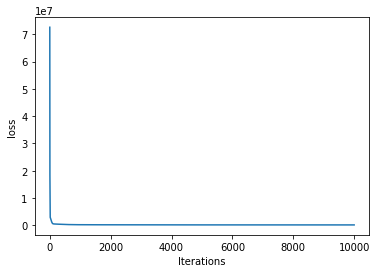

[('loss', 147866.23)]
[('loss', 146491.66)]
[('loss', 145053.08)]
[('loss', 143531.45)]
[('loss', 141821.78)]
[('loss', 139808.11)]
[('loss', 137167.16)]
[('loss', 134133.72)]
[('loss', 130907.04)]
[('loss', 127747.81)]


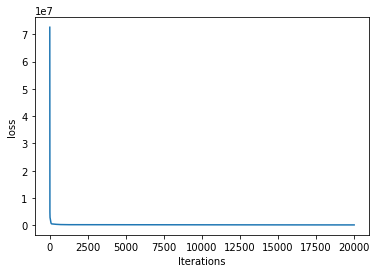

[('loss', 124763.234)]
[('loss', 121976.05)]
[('loss', 119463.984)]
[('loss', 117165.48)]
[('loss', 114870.87)]
[('loss', 112699.33)]
[('loss', 110294.64)]
[('loss', 108260.555)]
[('loss', 106279.31)]
[('loss', 104350.055)]


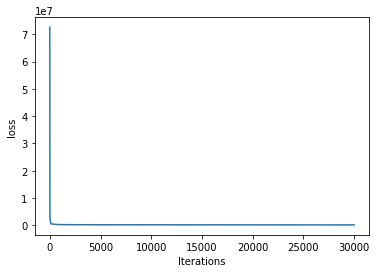

[('loss', 102302.195)]
[('loss', 100207.2)]
[('loss', 98219.66)]
[('loss', 96138.34)]
[('loss', 94021.4)]
[('loss', 91979.52)]


In [ ]:
val_log = None
# update = "adt_brsg"
# update = "trans"
update = "true_qs"
while len(full_train_logs['loss_evals']) < n_training_iters:
    demo_batch = sample_batch(nn_rollouts, train_idxes, batch_size)
    t = len(full_train_logs['loss_evals'])
    train_log = compute_batch_loss(demo_batch, constraints, step=True, update=update, t=t, true_qs=true_qs)
    if val_log is None or len(full_train_logs['loss_evals']) % val_update_freq == 0:
        val_log = compute_batch_loss(val_demo_batch, constraints, step=False, update=update, t=t, true_qs=true_qs)

    if len(full_train_logs['loss_evals']) % 1000 == 0:
#         print(t, val_log['loss'])
          print([(key,val_log[key]) for key in val_log.keys()])
    for k, v in train_log.items():
        full_train_logs['%s_evals' % k].append(v)
    for k, v in val_log.items():
        full_train_logs['val_%s_evals' % k].append(v)
    if len(full_train_logs['loss_evals']) % 10000 == 0:
        for k in ['val_loss_evals','val_ntll_evals','val_nall_evals','val_tde_evals']:
            if len(full_train_logs[k]) > 0:
                plt.xlabel('Iterations')
                plt.ylabel(k.split('_')[1])
                plt.plot(full_train_logs[k])
                plt.show()

In [ ]:
tts = np.arange(2)
acts = np.arange(mdp.nA) 
adt_samples = np.transpose([np.tile(tts, len(acts)), np.repeat(acts, len(tts))])
adt_samples = adt_samples[adt_samples[:,0].argsort()]

In [ ]:
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

In [ ]:
adt_samples

In [ ]:
softmax(adt_probs)

In [ ]:
print(reward_map)

In [ ]:
states = featurize_states(np.arange(mdp.nS))
q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
# q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

In [ ]:
# i,n=200,30
# states, actions = nn_rollouts[1][i:i+n], nn_rollouts[2][i:i+n] #featurize_states(np.arange(mdp.nS))
# q_vals, likelihoods, qsas, vs = sess.run([demo_q_t, act_log_likelihoods,tf.gather_nd(demo_q_t, action_indexes), demo_v_t],
#                                feed_dict={demo_obs_t_feats_ph:states,
#                                             demo_act_t_ph:actions,
#                                             demo_batch_size_ph: n})

In [ ]:
evals = [constraint_q_ts, constraint_adt_pred_probs, constraint_adt_pred_dir, adt_target_t, ca_indexes, cqtp1_misshaped, constraint_q_tp1, constraint_v_tp1, constraint_sprimes_reshaped, adt_V, true_q_errs]
c_qs, pred_probs, pred_dirs, adt_targs, acties, cq1, cq2, cv, cspr, av, tqes  = sess.run(evals,
                        feed_dict={constraint_obs_t_feats_ph: constraints[0],
                                    constraint_act_t_ph: constraints[1],
                                    constraint_rew_t_ph: constraints[2],
                                    constraint_next_obs_t_feats_ph: constraints[3],
                                    constraint_tile_t_ph: constraints[4],
                                    constraint_batch_size_ph: constraints[0].shape[0],
                                    true_qs_ph: true_qs})

In [ ]:
constraints[0][t_ind], constraints[1][t_ind], constraints[2][t_ind], constraints[4][t_ind], c_qs[t_ind], true_qs[t_ind], tqes[t_ind] #, adt_targs[t_ind], pred_probs[t_ind], cv[t_ind], cq2[t_ind], constraints[3][t_ind], av[t_ind]

In [ ]:
constraints[0][t_ind], constraints[1][t_ind], constraints[2][t_ind], constraints[4][t_ind], c_qs[t_ind], true_qs[t_ind], tqes[t_ind] #, adt_targs[t_ind], pred_probs[t_ind], cv[t_ind], cq2[t_ind], constraints[3][t_ind], av[t_ind]

In [ ]:
np.where(cq2 > 50)

In [ ]:
np.where((constraints[0] == np.array([4,1])).all(axis=1))

In [ ]:
t_ind = 337

In [ ]:
plot_values(mdp, q_vals)

In [ ]:
Qs = tabsoftq_learn_Qs(mdp)

In [ ]:
plot_values(mdp, Qs)

In [ ]:
q_vals - Qs

In [ ]:
test_constraint_adt_pred_probs =  tf.placeholder(tf.float32, [None, n_dirs], name="tpp")
test_constraint_q_t_ph = tf.placeholder(tf.float32, [None], name="tcq")
test_constraint_q_tp1_ph = tf.placeholder(tf.float32, [None, n_dirs, n_act_dim], name="tcqp1")
test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
indiv_errs = test_constraint_q_t_ph - test_adt_target
test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)

In [ ]:
sa = np.transpose([np.tile(np.arange(mdp.nS), mdp.nA), np.repeat(np.arange(mdp.nA), mdp.nS)])
states, acts = sa[:,0], sa[:,1]

next_states = [[mdp.sd_to_sprime(s,d) for d in range(mdp.nD)] for s in states]
currQs = Qs[states,acts]
nextQs = Qs[next_states]

pred_probs = true_tps[acts,:,constraints[4].flatten()]

test_err, learned_err, targets = sess.run([test_adt_td_err, adt_td_err_sg, test_adt_target], feed_dict= {constraint_obs_t_feats_ph: constraints[0],
                                    constraint_act_t_ph: constraints[1],
                                    constraint_rew_t_ph: constraints[2],
                                    constraint_next_obs_t_feats_ph: constraints[3],
                                    constraint_tile_t_ph: constraints[4],
                                    constraint_batch_size_ph: constraints[0].shape[0],
                                    test_constraint_q_t_ph: currQs,
                                    test_constraint_q_tp1_ph: nextQs,
                                    test_constraint_adt_pred_probs: pred_probs})
print(test_err, learned_err)

In [ ]:
q_net_path = os.path.join(data_dir, 'true_q_8192.tf')
save_tf_vars(sess, q_scope, q_net_path)
# load_tf_vars(sess, invdyn_scope, invdyn_nr_path)

## IDL Only

In [ ]:
idl_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [ ]:
maxiter = 300


In [ ]:
Ti_thetas = T_estimate(adt_obs[train_demo_example_idxes])
Qi, Ri = None, mdp.rewards

In [ ]:
while len(idl_train_logs['tt_lls']) < maxiter:
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    #Should we initialize Qs or nah?
    tp_ll, dT_pol, Qi = eval_T_pol_likelihood_and_grad(Ti_thetas, Ri, batch_demo_sas, Q_inits=Qi)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ti_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ti_thetas, Qi)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ti_thetas))
    Ti_thetas += learning_rate * (dT_trans + dT_pol)
    
    print('%d %f %f %f %f' % (len(idl_train_logs['tt_lls']), vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    idl_train_logs['train_likelihoods'].append(train_likelihood)
    idl_train_logs['val_likelihoods'].append(val_likelihood)
    idl_train_logs['tp_lls'].append(tp_ll)
    idl_train_logs['tt_lls'].append(tt_ll)
    idl_train_logs['vp_lls'].append(vp_ll)
    idl_train_logs['vt_lls'].append(vt_ll)
    idl_train_logs['true_trans_loss'].append(ttd)

In [ ]:
plt.plot(idl_train_logs['vp_lls'])

In [ ]:
plt.plot(idl_train_logs['vt_lls'])

In [ ]:
plt.plot(idl_train_logs['val_likelihoods'])

In [ ]:
print(Qi[[s for s in range(nS) if mdp.get_tile_type(s)==1]])

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qi))
print(softmax(Ti_thetas))

In [ ]:
tabsoftq_gen_pol_probs(Qi)[:,4]

In [ ]:
print(softmax(Ti_thetas)) # - softmax(T_estimate(adt_obs[train_demo_example_idxes])))

In [ ]:
test_T_likelihood(softmax(Ti_thetas), val_sas_obs, val_adt_obs)

In [ ]:
test_T_likelihood(softmax(T_estimate(adt_obs[train_demo_example_idxes])), val_sas_obs, val_adt_obs)

In [ ]:
test_T_likelihood(true_tps, val_sas_obs, val_adt_obs)

In [ ]:
true_trans_loss(softmax(Ti_thetas))

In [ ]:
softmax(Ti_thetas)

In [ ]:
true_trans_loss(softmax(T_estimate(adt_obs[train_demo_example_idxes])))

In [ ]:
softmax(T_estimate(adt_obs[train_demo_example_idxes]))

In [ ]:
plot_values(mdp, Qi)

In [ ]:
plot_values(mdp, exQs)

## SERD only

In [ ]:
serd_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [ ]:
Ts_thetas = T_estimate(adt_obs[train_demo_example_idxes]) #np.log(Tps2+.000000001)
feats = mdp.feature_map
Rs_thetas = np.random.normal(loc=1,scale=0.1,size=feats.shape[1])
Qs = None

In [ ]:
maxiter = 300
t_learning_rate = lambda t: 0 if t<20 else 3 - (2 * int(t/(maxiter/2)))
r_learning_rate = lambda t: 2e-1 if t<20 else 1e-1

In [ ]:
while len(serd_train_logs['tt_lls']) < maxiter:
    prevQs = Qs.copy() if Qs is not None else None
    t = len(serd_train_logs['tt_lls'])
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    Rs = feats.dot(Rs_thetas)
    tp_ll, dT_pol, dR_pol, Qs = eval_TR_pol_likelihood_and_grad(Ts_thetas, Rs, feats, batch_demo_sas, Q_inits=Qs)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ts_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ts_thetas, Qs)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ts_thetas))
    Rs_thetas += r_learning_rate(t) * dR_pol
    Ts_thetas += t_learning_rate(t) * (dT_trans + dT_pol)

#     print(dT_trans)
#     print(dT_pol)
#     print(softmax(Ts_thetas))
#     print(dR_pol * r_learning_rate(t))
#     print(Rs_thetas)
#     if prevQs is not None:
#         print("Q_diff")
#         print(np.linalg.norm(Qs-prevQs))

    
    print('%d %f %f %f %f' % (t, vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    serd_train_logs['train_likelihoods'].append(train_likelihood)
    serd_train_logs['val_likelihoods'].append(val_likelihood)
    serd_train_logs['tp_lls'].append(tp_ll)
    serd_train_logs['tt_lls'].append(tt_ll)
    serd_train_logs['vp_lls'].append(vp_ll)
    serd_train_logs['vt_lls'].append(vt_ll)
    serd_train_logs['true_trans_loss'].append(ttd)

In [ ]:
print(softmax(Ts_thetas))

In [ ]:
print(Rs_thetas)

In [ ]:
true_trans_loss(softmax(Ts_thetas))

In [ ]:
plt.plot(serd_train_logs['vp_lls'][:250])
plt.plot(idl_train_logs['vp_lls'][:250])

In [ ]:
plt.plot(serd_train_logs['vt_lls'][:250])
plt.plot(idl_train_logs['vt_lls'][:250])

In [ ]:
plt.plot(serd_train_logs['val_likelihoods'], label = "SERD")
plt.plot(idl_train_logs['val_likelihoods'], label = "IDL")
plt.title("Log likelihood of Demonstrations")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Log Likelihood")
plt.legend()

In [ ]:
plt.plot(serd_train_logs['true_trans_loss'], label = "SERD")
plt.plot(idl_train_logs['true_trans_loss'], label = "IDL")
plt.title("Square Error of Learned Transition Parameters")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Summed Square Error")
plt.legend()

## Comparison Tests

In [ ]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [ ]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [ ]:
print(demo_stats(mdp, SERD_demos))

In [ ]:
print(demo_stats(mdp, IDL_demos))

In [ ]:
plot_values(mdp, Qs)

In [ ]:
plot_values(mdp, Qi)

In [ ]:
print(reward_map[5][0], Qi[2], Q[2])

### Transfer

In [ ]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

In [ ]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.nA
nS = mdp.nS

In [ ]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [ ]:
print(demo_stats(mdp, IDL_trans_demos))

In [ ]:
print(demo_stats(mdp, SERD_trans_demos))

In [ ]:
plot_values(mdp, Qit)

In [ ]:
plot_values(mdp, Qst)

In [ ]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)

In [ ]:
mdp.get_possible_sprimes(np.array([[0,0],[0,1]]))

In [ ]:
i = 15
mdp.get_direction_moved(nn_rollouts[0][i][0],nn_rollouts[0][i+1][0])

In [ ]:
nn_rollouts[0][i], nn_rollouts[0][i+1]

In [ ]:
nn_rollouts[0][:30]